<a href="https://colab.research.google.com/github/engrlakshmi/A-B-testing-for-marketing-campagin/blob/main/aws_ec2_forecast_engine_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 AWS EC2 Daily Forecasting Engine with ADF Test & Metrics
Forecasting AWS EC2 spend using ARIMA and XGBoost models,
with financial simulation, performance metrics, and ADF test for stationarity.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
plt.style.use('seaborn-v0_8')
np.random.seed(42)

## 📊 Step 1. Load Daily EC2 Data

In [4]:
df = pd.read_csv('aws_ec2_daily_forecast_data.csv', parse_dates=['date'])
df.set_index('date', inplace=True)
print('✅ Dataset Loaded Successfully!')
df.head()

✅ Dataset Loaded Successfully!


,workload,spend_on_demand,spend_savings_plan,spend_reserved_instance
date,,,,
2023-01-01,1024.835708,122.980285,81.986857,61.490142
2023-01-02,997.164302,119.659716,79.773144,59.829858
2023-01-03,1040.538696,124.864643,83.243096,62.432322
2023-01-04,1088.380983,130.605718,87.070479,65.302859
2023-01-05,1004.594749,120.551370,80.367580,60.275685


## 🔬 Step 2. ADF Test for Stationarity

In [6]:
adf_result = adfuller(df['spend_on_demand'])
print(f'ADF Statistic: {adf_result[0]:.3f}')
print(f'p-value: {adf_result[1]:.3f}')
for key, value in adf_result[4].items():
    print(f'Critical Value ({key}): {value:.3f}')
if adf_result[1] > 0.05:
    print('❌ Series is NOT stationary (p > 0.05). Consider differencing or detrending.')
else:
    print('✅ Series is stationary (p ≤ 0.05).')

ADF Statistic: -0.986
p-value: 0.758
Critical Value (1%): -3.437
Critical Value (5%): -2.864
Critical Value (10%): -2.568
❌ Series is NOT stationary (p > 0.05). Consider differencing or detrending.


In [7]:
df['log_spend'] = np.log(df['spend_on_demand'])
df['log_spend_diff'] = df['log_spend'].diff().dropna()
adf_result_logdiff = adfuller(df['log_spend_diff'].dropna())
print(f"ADF Statistic (log diff): {adf_result_logdiff[0]:.3f}")
print(f"p-value: {adf_result_logdiff[1]:.3f}")


ADF Statistic (log diff): -16.245
p-value: 0.000


In [9]:
df.shape

(1004, 6)

## 📈 Step 3. Compute Performance Metrics

In [ ]:
metrics = {
    'Mean Spend': df['spend_on_demand'].mean(),
    'Std Deviation': df['spend_on_demand'].std(),
    'Coefficient of Variation (%)': (df['spend_on_demand'].std() / df['spend_on_demand'].mean()) * 100,
    'Max Spend': df['spend_on_demand'].max(),
    'Min Spend': df['spend_on_demand'].min()
}
pd.DataFrame(metrics, index=['spend_on_demand']).T

## 🔮 Step 4. ARIMA Forecasting

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA Forecast MAE: 7.88


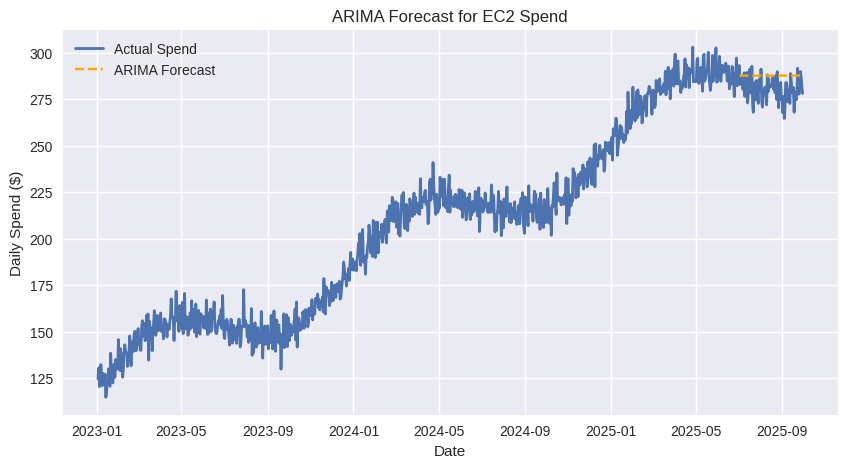

In [13]:
train = np.log(df['spend_on_demand'][:-90])  # log-transform only
test = np.log(df['spend_on_demand'][-90:])

model_arima = ARIMA(train, order=(1,1,1))  # <-- d=1 means first difference
fitted_arima = model_arima.fit()
forecast_log = fitted_arima.forecast(steps=90)

# Convert back from log to actual values
forecast_arima = np.exp(forecast_log)

mae_arima = mean_absolute_error(np.exp(test), forecast_arima)
print(f'ARIMA Forecast MAE: {mae_arima:.2f}')
plt.figure(figsize=(10,5))
plt.plot(df.index, df['spend_on_demand'], label='Actual Spend', linewidth=2)
plt.plot(test.index, forecast_arima, '--', label='ARIMA Forecast', color='orange')
plt.title('ARIMA Forecast for EC2 Spend')
plt.xlabel('Date')
plt.ylabel('Daily Spend ($)')
plt.legend()
plt.show()

## 🤖 Step 5. XGBoost Forecasting

Enhanced XGBoost Forecast MAE: 4.80


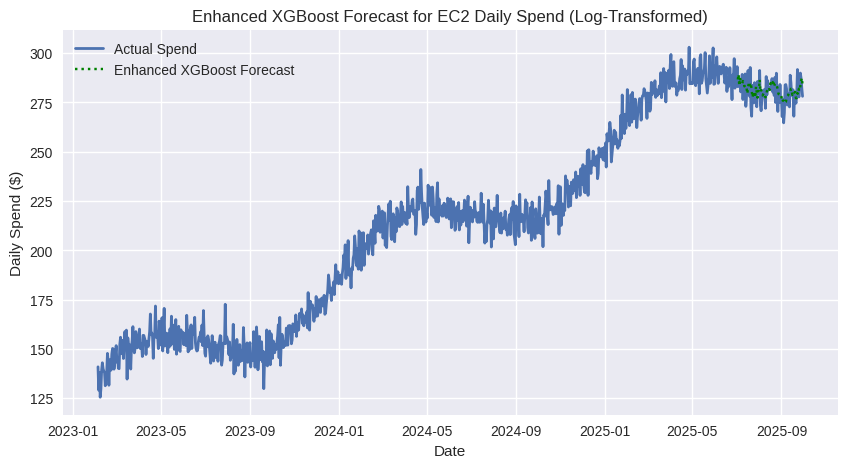

In [23]:
from xgboost import XGBRegressor, plot_importance
# -- Target transform
df['log_spend'] = np.log(df['spend_on_demand'])

# -- Features: lags, rolling, calendar
df['lag1'] = df['log_spend'].shift(1) #Create lag features to give the model recent history:
df['lag2'] = df['log_spend'].shift(2)
df['lag3'] = df['log_spend'].shift(3)
df['rolling_mean_7'] = df['log_spend'].rolling(7).mean() #Add rolling statistics that summarize recent behavior
df['rolling_std_7'] = df['log_spend'].rolling(7).std()
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month # Add calendar features:

df.dropna(inplace=True)

X = df[['lag1', 'lag2', 'lag3', 'rolling_mean_7', 'rolling_std_7', 'dayofweek', 'month']]
y = df['log_spend']

# -- Time-based split (last 90 days as test)
test_size = 90
X_train, X_test = X[:-test_size], X[-test_size:]
y_train, y_test = y[:-test_size], y[-test_size:]

# -- Train XGBoost
xgb = XGBRegressor(n_estimators=500, learning_rate=0.03, max_depth=5,
                   subsample=0.9, colsample_bytree=0.9, random_state=42, base_score=0.5)
xgb.fit(X_train, y_train)

# -- Predict and invert log
y_pred_log = xgb.predict(X_test)
y_pred = np.exp(y_pred_log)
y_test_exp = np.exp(y_test)

# -- Metric
mae_xgb = mean_absolute_error(y_test_exp, y_pred)
print(f'Enhanced XGBoost Forecast MAE: {mae_xgb:.2f}')

# -- Plot actual vs forecast (test window)
plt.figure(figsize=(10,5))
plt.plot(df.index, np.exp(df['log_spend']), label='Actual Spend', linewidth=2)
plt.plot(y_test.index, y_pred, ':', label='Enhanced XGBoost Forecast', color='green')
plt.title('Enhanced XGBoost Forecast for EC2 Daily Spend (Log-Transformed)')
plt.xlabel('Date')
plt.ylabel('Daily Spend ($)')
plt.legend()
plt.grid(True)
plt.show()

<Figure size 600x1200 with 0 Axes>

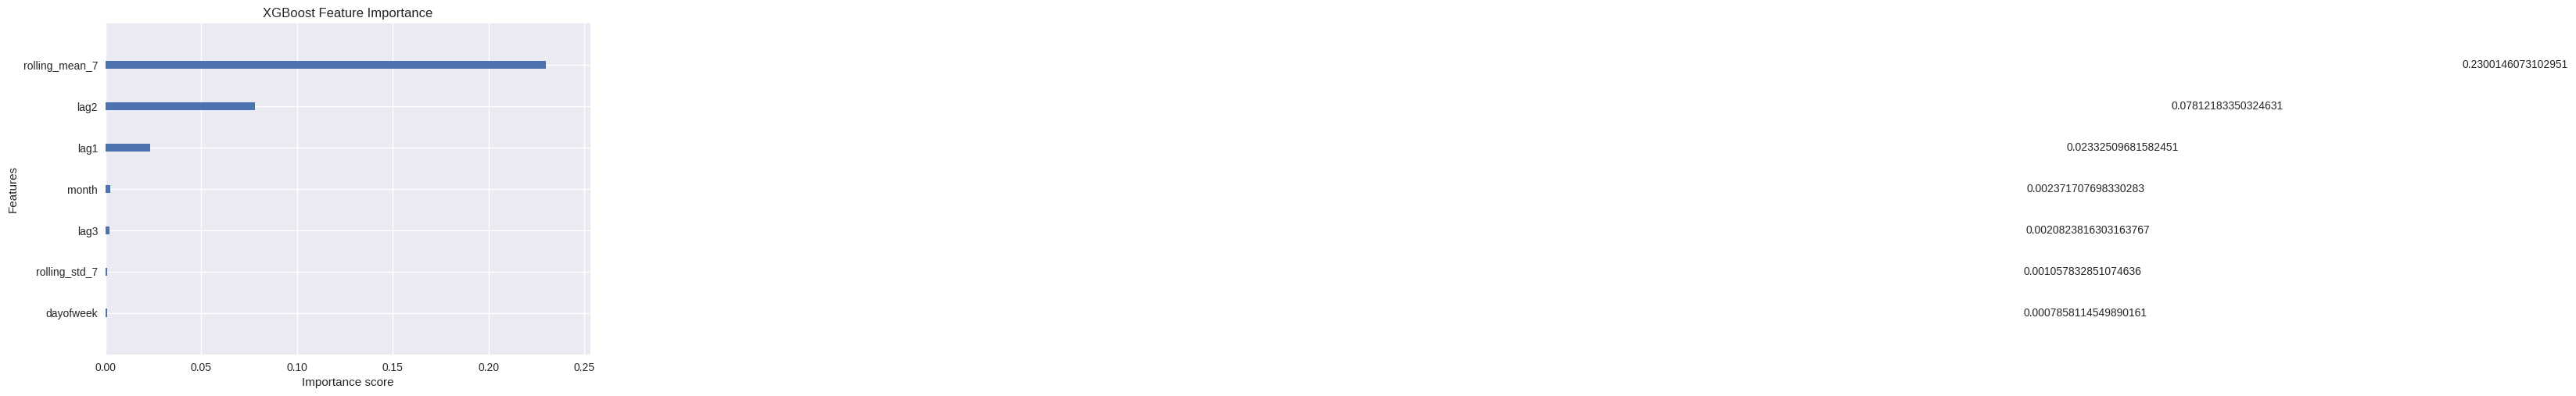

In [21]:
# -- Feature importance
plt.figure(figsize=(6,12))
plot_importance(xgb, max_num_features=7, importance_type='gain', title='XGBoost Feature Importance')
plt.show()